In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

In [2]:
# Reading & Cleaning sub indicators
Sub=pd.read_excel('sub_indicators_081421.xlsx')
Sub.index=Sub['province']
Sub.drop('province',axis='columns',inplace=True)



In [3]:
def Standardize(Ser):
    result=(Ser-Ser.mean())/Ser.std()
    return result

ind_type=pd.read_excel(r'D:\Personal\University\Master\Thesis\Aggregation-Weighting\indicator_type.xlsx',sheet_name='Sheet1')
ind_type.drop('pop_growth',axis=1,inplace=True)
ind_type.drop([0,1],axis=0,inplace=True)
ind_type['withdraw_gw_ratio']='l'
ind_type['damcap_rwr_ratio']='b'
ind_type.index=['type']

Standardized_data=pd.DataFrame(index=Sub.index)
for col in Sub.columns:
    if ind_type.loc['type',col]=='b':
        Standardized_data[col]=Standardize(Sub.loc[:,col])
    else:
        Standardized_data[col]=Standardize(-Sub.loc[:,col])    
res_sub_columns=['ACV','MCV','Dag','Dan','GWDagr','GWDind','GWDurb','GWDrur','SWS','GWS','APA','ATA','IRWR']
acc_sub_columns=['WAurb','WArur','USP','SAurb','SArur','TPC','WQ','DC']
eco_sub_columns=['AE','MI','EL','NRWurb','NRWrur','IE']
sub_columns=res_sub_columns+acc_sub_columns+eco_sub_columns 
Standardized_data.columns=sub_columns

In [4]:
# Reading Normalized indicators based on Phillis method
Normalized_main=pd.read_excel('Normalized Sub Indicators.xlsx')
Normalized_main.drop(1,axis='index',inplace=True)
Normalized_main.columns=Normalized_main.iloc[0,:]
Normalized_main.drop(0,axis='index',inplace=True)
Normalized_main.rename({'Indicator':'province'},axis='columns',inplace=True)
Normalized_main.index=Normalized_main['province']
Normalized_main.drop('province',axis='columns',inplace=True)
sub_columns1_list= ['R1','R1','R2','R2','R3','R3','R3','R3','R4','R4','R5','R5','R7']+['A1','A1','A1','A2','A2','A2','A3','A3']+['E1','E1','E1','E2','E2','E3']
sub_columns2_list=list(Normalized_main.columns)

In [5]:
arrayeco=['E1','E1','E1','E2','E2','E3','E3','E3']
arrayacc=['A1','A1','A1','A2','A2','A2','A3','A3','A3','A3']
arrayres=['R1','R1','R2','R2','R3','R3','R3','R3','R4','R4','R5','R5','R5','R6','R6','R7','R7','R7','R7']
arraywsi=['WSI','WSI','WSI']
Agg_lvl=arraywsi+arrayres+arrayacc+arrayeco

In [6]:
#PCA weights df
PCA_weights=pd.read_csv('PCA_weights.csv')
PCA_weights.drop('Unnamed: 0',axis=1,inplace=True)
multi_columns=[Agg_lvl]+[list(PCA_weights.iloc[0])]
PCA_weights.columns=pd.MultiIndex.from_arrays(multi_columns, names=('Aggregation Level', 'Indicator'))
PCA_weights.drop(0,inplace=True)
PCA_weights.index=['weights']
PCA_weights=PCA_weights.astype('float')

In [7]:
#AHP weights df
AHP_weights=pd.read_csv('AHP_weights.csv')
AHP_weights.drop('Aggregation Level',axis=1,inplace=True)
multi_columns=[Agg_lvl]+[list(AHP_weights.iloc[0])]
AHP_weights.columns=pd.MultiIndex.from_arrays(multi_columns, names=('Aggregation Level', 'Indicator'))
AHP_weights.drop(0,inplace=True)
AHP_weights.index=['weights']
AHP_weights=AHP_weights.astype('float')

In [8]:
#Equal weights df
Equal_weights=AHP_weights*0
agg=set(Agg_lvl)
for col in agg:
    size=Equal_weights[col].size
    Equal_weights[col]=1/size
Equal_weights=Equal_weights.round(decimals=2)
Equal_weights=Equal_weights.astype('float')

In [9]:
# Defining Aggregation Methods
def weighted_addminagg(dfi,dfw,a=0.5):
    weight_array=np.array(dfw)[0]
    dfmin=dfi.min(axis=1)
    weighted_sum=dfi.multiply(weight_array,axis='columns').sum(axis=1)
    result=a*dfmin+(1-a)*weighted_sum
    return result

def weighted_addgeo(dfi,dfw,a=0.5):
    weight_array=np.array(dfw)[0]
    weighted_geomean=dfi.pow(weight_array,axis='columns').product(axis='columns')
    weighted_sum=dfi.multiply(weight_array,axis='columns').sum(axis=1)
    result= a*weighted_geomean+(1-a)*weighted_sum
    return result

In [10]:
# changing columns into multi index
arraycolumns=[sub_columns1_list]+[sub_columns2_list]
Normalized_main.columns=pd.MultiIndex.from_arrays(arraycolumns, names=('Aggregation Level', 'Indicator'))
Standardized_data.columns=pd.MultiIndex.from_arrays(arraycolumns, names=('Aggregation Level', 'Indicator'))


In [11]:
def norm_lvl2_addmin(normalized_df,weights_df,a=0.5):
    normalized_lvl2=pd.DataFrame(normalized_df[('R4','SWS')]*0,index=normalized_df.index)
    normalized_lvl2.columns=pd.MultiIndex.from_arrays([['R5'],['CV']], names=('Aggregation Level', 'Indicator'))
    normalized_lvl2[('R5','CV')]=weighted_addminagg(normalized_df.loc[:,'R1'],weights_df['R1'],a).round(decimals=4)
    normalized_lvl2[('R6','GD')]=weighted_addminagg(normalized_df.loc[:,'R2'],weights_df['R2'],a).round(decimals=4)
    normalized_lvl2[('R6','GWD')]=weighted_addminagg(normalized_df.loc[:,'R3'],weights_df['R3'],a).round(decimals=4)
    return normalized_lvl2
def norm_lvl2_addgeo(normalized_df,weights_df,a=0.5):
    normalized_lvl2=pd.DataFrame(normalized_df[('R4','SWS')]*0,index=normalized_df.index)
    normalized_lvl2.columns=pd.MultiIndex.from_arrays([['R5'],['CV']], names=('Aggregation Level', 'Indicator'))
    normalized_lvl2[('R5','CV')]=weighted_addgeo(normalized_df.loc[:,'R1'],weights_df['R1'],a).round(decimals=4)
    normalized_lvl2[('R6','GD')]=weighted_addgeo(normalized_df.loc[:,'R2'],weights_df['R2'],a).round(decimals=4)
    normalized_lvl2[('R6','GWD')]=weighted_addgeo(normalized_df.loc[:,'R3'],weights_df['R3'],a).round(decimals=4)
    return normalized_lvl2


In [12]:
# def indicators_df_addmin(normalized_df,weights_df,a=0.5):
#     normalized_lvl2=norm_lvl2_addmin(normalized_df,weights_df,a=0.5)
#     indicators=pd.DataFrame(normalized_df[('R4','SWS')]*0,index=normalized_df.index)
#     indicators.columns=pd.MultiIndex.from_arrays([['Resource'],['IRWR']], names=('Dimension', 'Indicator'))
#     indicators[('Resource','IRWR')]=normalized_df.loc[:,('R7','IRWR')]
#     indicators[('Resource','CC')]=weighted_addminagg(normalized_lvl2['R5'].merge(normalized_df['R5'], left_index=True, right_index=True,how='outer'),weights_df['R5']).round(decimals=4)
#     indicators[('Resource','WS')]=weighted_addminagg(normalized_df.loc[:,'R4'],weights_df['R4']).round(decimals=4)
#     indicators.loc[normalized_lvl2[('R6','GD')]<0.8,('Resource','GW')]=weighted_addminagg(normalized_lvl2.loc[:,'R6'],weights_df['R6']).round(decimals=4)
#     indicators.loc[normalized_lvl2[('R6','GD')]>0.8,('Resource','GW')]=normalized_lvl2.loc[:,('R6','GD')]
#     indicators[('Access','DW')]=weighted_addminagg(normalized_df.loc[:,'A1'],weights_df['A1']).round(decimals=4)
#     indicators[('Access','WQ')]=normalized_df.loc[:,('A3','WQ')]
#     indicators[('Access','DC')]=normalized_df.loc[:,('A3','DC')]
#     indicators[('Access','SS')]=weighted_addminagg(normalized_df.loc[:,'A2'],weights_df['A2']).round(decimals=4)
#     indicators[('Economy','Eagr')]=weighted_addminagg(normalized_df.loc[:,'E1'],weights_df['E1']).round(decimals=4)
#     indicators[('Economy','IE')]=normalized_df.loc[:,('E3','IE')]
#     indicators[('Economy','NRW')]=weighted_addminagg(normalized_df.loc[:,'E2'],weights_df['E2']).round(decimals=4)
#     Dimensions=pd.DataFrame(index=normalized_df.index)
#     Dimensions['Resource']=weighted_addminagg(indicators[('Resource')],weights_df['R7']).round(decimals=4)
#     Dimensions['Access']=weighted_addminagg(indicators[('Access')],weights_df['A3']).round(decimals=4)
#     Dimensions['Economy']=weighted_addminagg(indicators[('Economy')],weights_df['E3']).round(decimals=4)
#     Dimensions['WSI']=weighted_addminagg(Dimensions,weights_df['WSI']).round(decimals=4                
#     return (indicators,Dimensions)

# def indicators_df_addgeo(normalized_df,weights_df,a=0.5):
#     normalized_lvl2=norm_lvl2_addmin(normalized_df,weights_df,a=0.5)
#     indicators=pd.DataFrame(normalized_df[('R4','SWS')]*0,index=normalized_df.index)
#     indicators.columns=pd.MultiIndex.from_arrays([['Resource'],['IRWR']], names=('Dimension', 'Indicator'))
#     indicators[('Resource','IRWR')]=normalized_df.loc[:,('R7','IRWR')]
#     indicators[('Resource','CC')]=weighted_addgeo(normalized_lvl2['R5'].merge(normalized_df['R5'], left_index=True, right_index=True,how='outer'),weights_df['R5']).round(decimals=4)
#     indicators[('Resource','WS')]=weighted_addgeo(normalized_df.loc[:,'R4'],weights_df['R4']).round(decimals=4)
#     # if a province has low groundwater reservoir deficit then high dependency on groundwater is considered okay i.e. if GD> 0.8 then GWD not involved in aggregation
#     indicators.loc[normalized_lvl2[('R6','GD')]<0.8,('Resource','GW')]=weighted_addgeo(normalized_lvl2.loc[:,'R6'],weights_df['R6']).round(decimals=4)
#     indicators.loc[normalized_lvl2[('R6','GD')]>0.8,('Resource','GW')]=normalized_lvl2.loc[:,('R6','GD')]
#     indicators[('Access','DW')]=weighted_addgeo(normalized_df.loc[:,'A1'],weights_df['A1']).round(decimals=4)
#     indicators[('Access','WQ')]=normalized_df.loc[:,('A3','WQ')]
#     indicators[('Access','DC')]=normalized_df.loc[:,('A3','DC')]
#     indicators[('Access','SS')]=weighted_addgeo(normalized_df.loc[:,'A2'],weights_df['A2']).round(decimals=4)
#     indicators[('Economy','Eagr')]=weighted_addgeo(normalized_df.loc[:,'E1'],weights_df['E1']).round(decimals=4)
#     indicators[('Economy','IE')]=normalized_df.loc[:,('E3','IE')]
#     indicators[('Economy','NRW')]=weighted_addgeo(normalized_df.loc[:,'E2'],weights_df['E2']).round(decimals=4)
#     Dimensions=pd.DataFrame(index=normalized_df.index)
#     Dimensions['Resource']=weighted_addgeo(indicators[('Resource')],weights_df['R7']).round(decimals=4)
#     Dimensions['Access']=weighted_addgeo(indicators[('Access')],weights_df['A3']).round(decimals=4)
#     Dimensions['Economy']=weighted_addgeo(indicators[('Economy')],weights_df['E3']).round(decimals=4)
#     Dimensions['WSI']=weighted_addgeo(Dimensions,weights_df['WSI']).round(decimals=4)
#     return (indicators,Dimensions)

In [13]:
def indicators_df(normalized_df,standardized_df,AHP_df,PCA_df,Equal_df,weighting='AHP',aggmethod='addmin',scaling='normalize', a=0.5):
    
    if weighting=='AHP':
        weights_df=AHP_df
    elif weighting=='PCA':
        weights_df=PCA_df
    elif weighting=='Equal':
        weights_df=Equal_df
        
    if scaling=='normalize':
        data=normalized_df
    elif scaling=='standardize':
        data=standardized_df
        
    if aggmethod=='addmin':
        normalized_lvl2=norm_lvl2_addmin(data,weights_df,0.5)
        indicators=pd.DataFrame(data[('R4','SWS')]*0,index=data.index)
        indicators.columns=pd.MultiIndex.from_arrays([['Resource'],['IRWR']], names=('Dimension', 'Indicator'))
        indicators[('Resource','IRWR')]=data.loc[:,('R7','IRWR')]
        indicators[('Resource','CC')]=weighted_addminagg(normalized_lvl2['R5'].merge(data['R5'], left_index=True, right_index=True,how='outer'),weights_df['R5']).round(decimals=4)
        indicators[('Resource','WS')]=weighted_addminagg(data.loc[:,'R4'],weights_df['R4']).round(decimals=4)
        indicators.loc[normalized_lvl2[('R6','GD')]<0.8,('Resource','GW')]=weighted_addminagg(normalized_lvl2.loc[:,'R6'],weights_df['R6']).round(decimals=4)
        indicators.loc[normalized_lvl2[('R6','GD')]>0.8,('Resource','GW')]=normalized_lvl2.loc[:,('R6','GD')]
        indicators[('Access','DW')]=weighted_addminagg(normalized_df.loc[:,'A1'],weights_df['A1']).round(decimals=4)
        indicators[('Access','WQ')]=data.loc[:,('A3','WQ')]
        indicators[('Access','DC')]=data.loc[:,('A3','DC')]
        indicators[('Access','SS')]=weighted_addminagg(data.loc[:,'A2'],weights_df['A2']).round(decimals=4)
        indicators[('Economy','Eagr')]=weighted_addminagg(data.loc[:,'E1'],weights_df['E1']).round(decimals=4)
        indicators[('Economy','IE')]=data.loc[:,('E3','IE')]
        indicators[('Economy','NRW')]=weighted_addminagg(data.loc[:,'E2'],weights_df['E2']).round(decimals=4)
        Dimensions=pd.DataFrame(index=data.index)
        Dimensions['Resource']=weighted_addminagg(indicators[('Resource')],weights_df['R7']).round(decimals=4)
        Dimensions['Access']=weighted_addminagg(indicators[('Access')],weights_df['A3']).round(decimals=4)
        Dimensions['Economy']=weighted_addminagg(indicators[('Economy')],weights_df['E3']).round(decimals=4)
        Dimensions['WSI']=weighted_addminagg(Dimensions,weights_df['WSI']).round(decimals=4)
    elif aggmethod=='addgeo':
        normalized_lvl2=norm_lvl2_addmin(data,weights_df,a)
        indicators=pd.DataFrame(data[('R4','SWS')]*0,index=data.index)
        indicators.columns=pd.MultiIndex.from_arrays([['Resource'],['IRWR']], names=('Dimension', 'Indicator'))
        indicators[('Resource','IRWR')]=data.loc[:,('R7','IRWR')]
        indicators[('Resource','CC')]=weighted_addgeo(normalized_lvl2['R5'].merge(normalized_df['R5'], left_index=True, right_index=True,how='outer'),weights_df['R5'],a).round(decimals=4)
        indicators[('Resource','WS')]=weighted_addgeo(normalized_df.loc[:,'R4'],weights_df['R4']).round(decimals=4)
        indicators.loc[normalized_lvl2[('R6','GD')]<0.8,('Resource','GW')]=weighted_addgeo(normalized_lvl2.loc[:,'R6'],weights_df['R6'],a).round(decimals=4)
        indicators.loc[normalized_lvl2[('R6','GD')]>0.8,('Resource','GW')]=normalized_lvl2.loc[:,('R6','GD')]
        indicators[('Access','DW')]=weighted_addgeo(data.loc[:,'A1'],weights_df['A1'],a).round(decimals=4)
        indicators[('Access','WQ')]=data.loc[:,('A3','WQ')]
        indicators[('Access','DC')]=data.loc[:,('A3','DC')]
        indicators[('Access','SS')]=weighted_addgeo(data.loc[:,'A2'],weights_df['A2'],a).round(decimals=4)
        indicators[('Economy','Eagr')]=weighted_addgeo(data.loc[:,'E1'],weights_df['E1'],a).round(decimals=4)
        indicators[('Economy','IE')]=data.loc[:,('E3','IE')]
        indicators[('Economy','NRW')]=weighted_addgeo(data.loc[:,'E2'],weights_df['E2'],a).round(decimals=4)
        Dimensions=pd.DataFrame(index=data.index)
        Dimensions['Resource']=weighted_addgeo(indicators[('Resource')],weights_df['R7'],a).round(decimals=4)
        Dimensions['Access']=weighted_addgeo(indicators[('Access')],weights_df['A3'],a).round(decimals=4)
        Dimensions['Economy']=weighted_addgeo(indicators[('Economy')],weights_df['E3'],a).round(decimals=4)
        Dimensions['WSI']=weighted_addgeo(Dimensions,weights_df['WSI'],a).round(decimals=4)        
    return (indicators,Dimensions)

In [17]:
comparison_index=list(Normalized_main.index)+['Aggregation_method','Weighting_method','Scaling_method','alpha']
WSI_methods=pd.DataFrame(index=comparison_index)


for agg in ['addmin','addgeo']:
    for alpha in [0.0.2,0.4,0.5,0.6,0.8,1]:
        for scale in ['normalize','standardize']:
            for weight in ['AHP','PCA','Equal']:
                if (agg=='addmin' and alpha == 0):
                    pass
                else:
                    name=agg+"_"+weight+'_'+scale+'_'+str(alpha)
                    WSI_methods.loc['azsh':'yazd',name]=indicators_df(Normalized_main,Standardized_data,AHP_weights,PCA_weights,Equal_weights,weighting=weight,aggmethod=agg,scaling=scale,a=alpha)[1]['WSI']
                    WSI_methods.loc['Aggregation_method',name]=agg
                    WSI_methods.loc['Weighting_method',name]=weight
                    WSI_methods.loc['Scaling_method',name]=scale
                    WSI_methods.loc['alpha',name]=alpha
# WSI_methods.to_excel('WSI_methods(0-0.5-1).xlsx')

In [19]:
WSI_ranks=WSI_methods.loc['azsh':'yazd',:].rank(ascending=False)
# WSI_ranks.to_excel('Ranks in different methods((0-0.5-1)).xlsx')

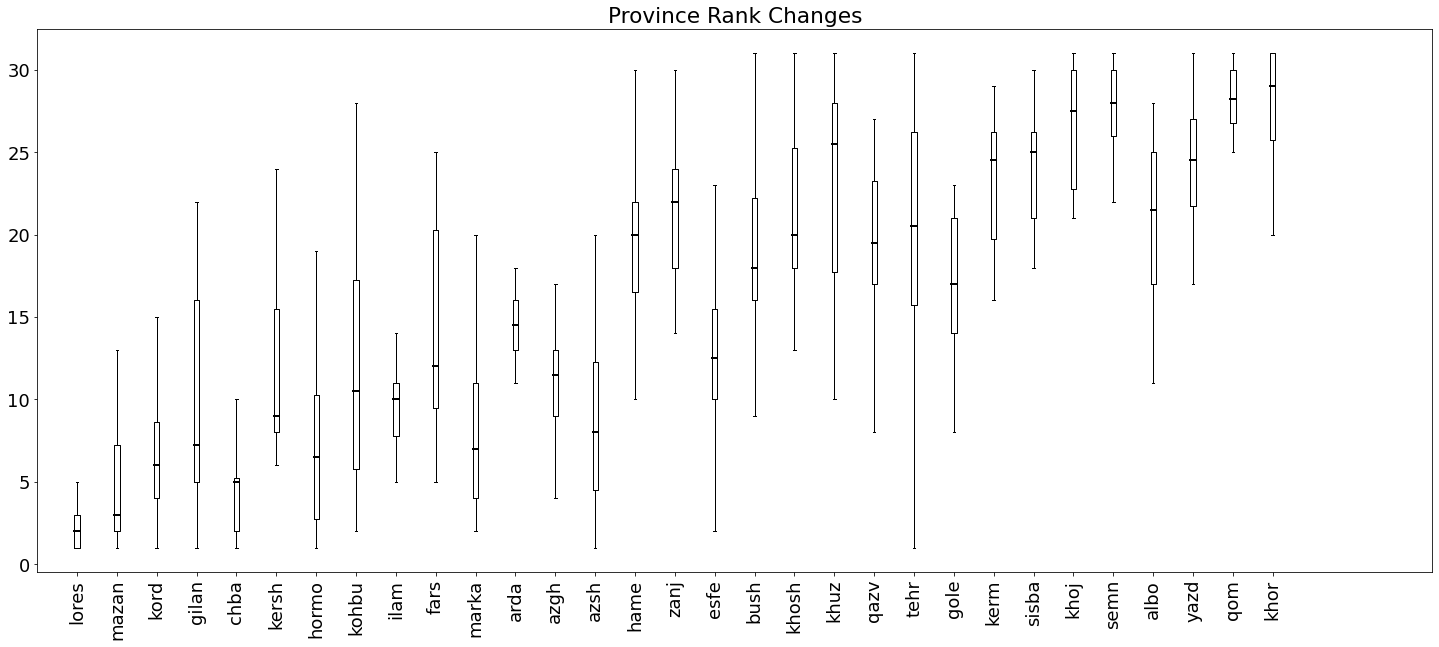

In [33]:
import matplotlib.pyplot as plt
df=WSI_ranks.sort_values('addmin_AHP_normalize_0.5').transpose()
fig, ax = plt.subplots()
plt.cla()
plt.rcParams["figure.figsize"] = (25,8)
ax.set_title('Province Rank Changes')
medianprops = dict(linestyle='-', linewidth=2, color='black')
ax.boxplot(df, showfliers=False,widths=0.13,labels=df.columns,medianprops =medianprops)
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 18})
ax.set_xlim(0,35)
# plt.savefig('Rank Changes Closer(0.2 intervals).png')
plt.show()